# Qubit gate decompositions of fermionic gates

In this page, we discuss the gate decompositions of the fermionic gates included in ffsim.

In [1]:
import numpy as np
from qiskit.circuit import QuantumCircuit, QuantumRegister

import ffsim

# Let's use 4 spatial orbitals with 2 alpha electrons and 2 beta electrons.
norb = 4
nelec = (2, 2)

# Initialize qubits
qubits = QuantumRegister(2 * norb, name="q")

# Initialize random number generator
rng = np.random.default_rng(1234)

## Hartree-Fock and Slater determinant preparation

Let's create a circuit with a Hartree-Fock state preparation gate. Then, let's decompose the circuit once and draw the output.

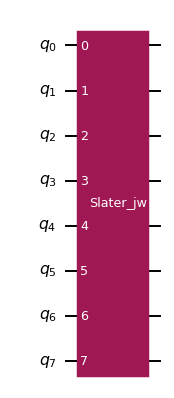

In [2]:
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)

circuit.decompose().draw("mpl", scale=0.7)

The Hartree-Fock gate has decomposed into a Slater determinant gate. This makes sense, because the Hartree-Fock state is a special case of a Slater determinant. Let's go further and decompose the circuit using two repetitions.

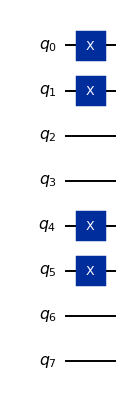

In [3]:
circuit.decompose(reps=2).draw("mpl", scale=0.7)

Finally, we see that the Hartree-Fock state preparation gate simply applies X gates to set the qubits corresponding to occupied orbitals to one.

The Hartree-Fock state is defined as having the lowest numbered orbitals occupied. If we want to produce a different electronic configuration, we can use a more general Slater determinant preparation gate. Let's do this using a configuration obtained from the Hartree-Fock configuration by exciting one of the spin $\alpha$ electrons to the next orbital.

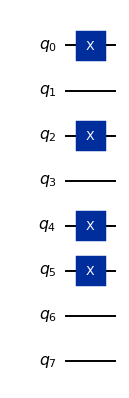

In [4]:
occupied_orbitals = ([0, 2], [0, 1])

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareSlaterDeterminantJW(norb, occupied_orbitals), qubits)

circuit.decompose().draw("mpl", scale=0.7)

A general Slater determinant is obtained by applying an [orbital rotation](orbital-rotation.ipynb) to an electronic configuration. Let's generate a random orbital rotation and use it to initialize the gate.

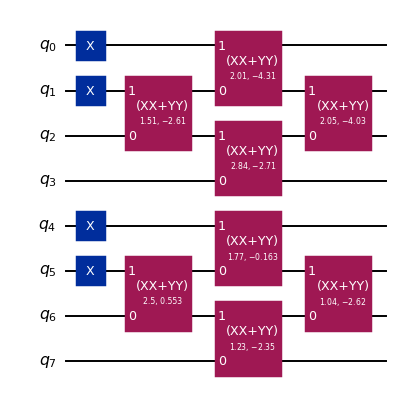

In [5]:
orbital_rotation = ffsim.random.random_unitary(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.PrepareSlaterDeterminantJW(
        norb, occupied_orbitals, orbital_rotation=orbital_rotation
    ),
    qubits,
)

circuit.decompose().draw("mpl", scale=0.7)

We see that the Slater determinant is prepared by applying X gates to prepare the Hartree-Fock configuration, and then applying a sequence of [XXPlusYYGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.XXPlusYYGate#xxplusyygate) to effect the orbital rotation. Note that the initial X gates prepare the Hartree-Fock configuration even though we specified a different one in the gate initialization. This happens because the Slater determinant gate decomposition is optimized to minimize the number of XXPlusYYGates in the result. The decomposition is more efficient than that of a general orbital rotation.

## Orbital rotation

A general orbital rotation decomposes into a sequence of XXPlusYYGates followed by a layer of [PhaseGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.PhaseGate#phasegate).

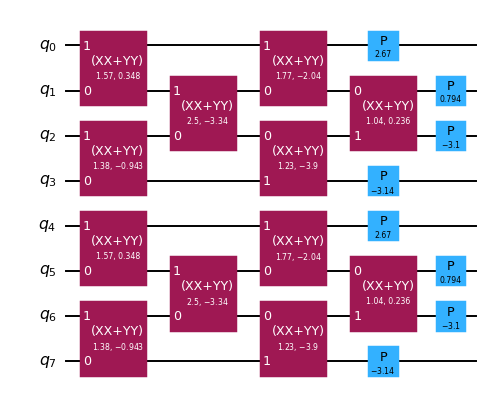

In [6]:
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.OrbitalRotationJW(norb, orbital_rotation), qubits)

circuit.decompose().draw("mpl", scale=0.7)

## Diagonal Coulomb evolution

Time evolution by a diagonal Coulomb Hamiltonian decomposes into a layer of PhaseGates followed by a sequence of [CPhaseGates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.CPhaseGate#cphasegate)

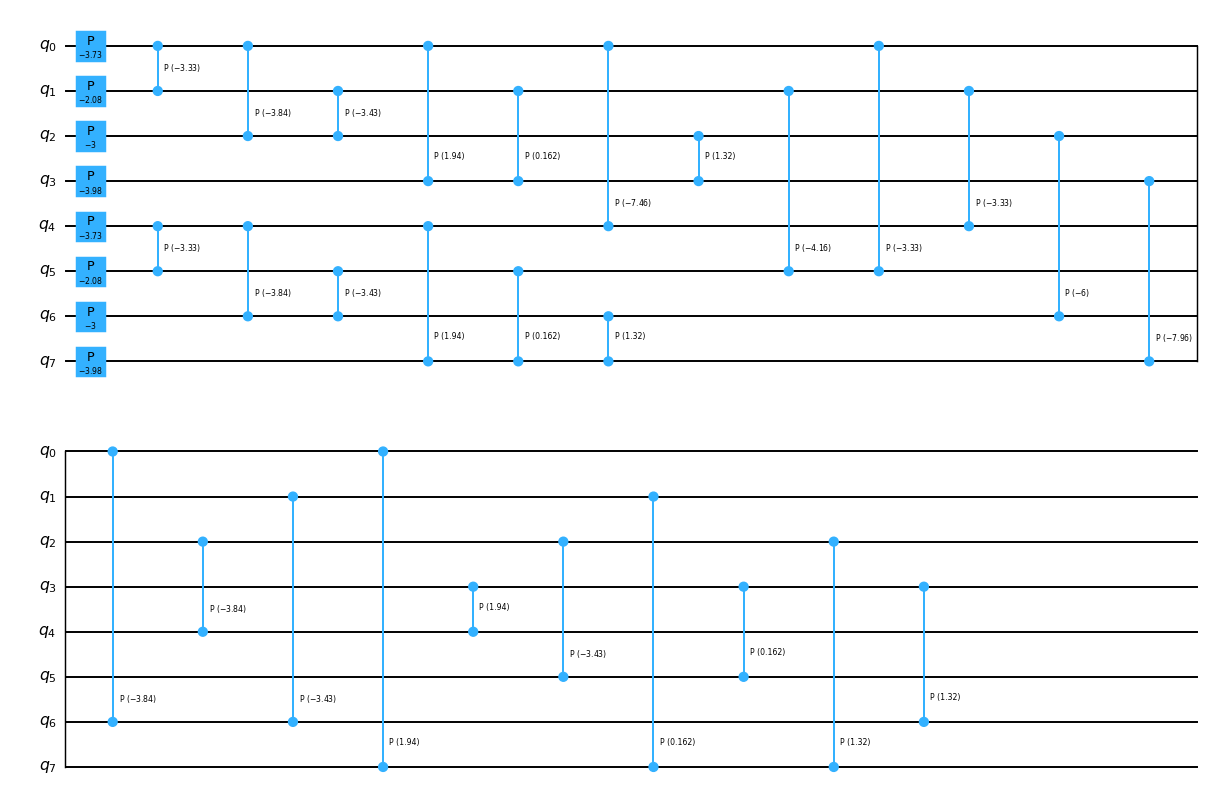

In [7]:
diag_coulomb_mat = ffsim.random.random_real_symmetric_matrix(norb, seed=rng)

circuit = QuantumCircuit(qubits)
circuit.append(
    ffsim.qiskit.DiagCoulombEvolutionJW(norb, diag_coulomb_mat, time=1.0), qubits
)

circuit.decompose().draw("mpl", scale=0.7)

## Unitary cluster Jastrow (UCJ) operator

A UCJ operator decomposes into a sequence of diagonal Coulomb evolutions sandwiched by orbital rotations. The number of diagonal Coulomb evolutions is equal to the number of ansatz repetitions (in this example, two).

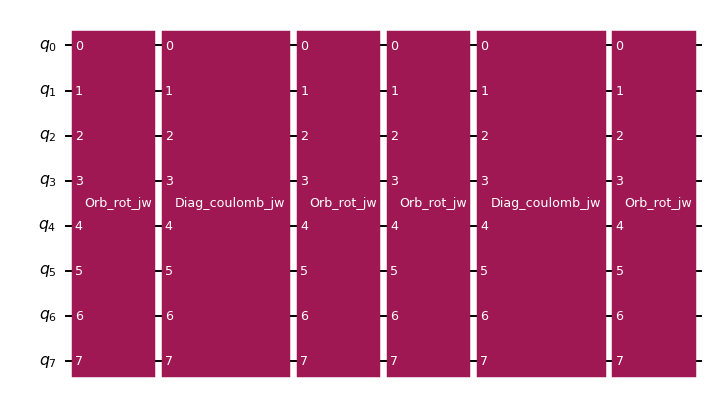

In [8]:
n_reps = 2
t2 = ffsim.random.random_t2_amplitudes(norb, nocc=2, dtype=float)
ucj_op = ffsim.UCJOperator.from_parameters(
    ffsim.UCJOperator.from_t_amplitudes(t2, n_reps=n_reps).to_parameters(),
    norb=norb,
    n_reps=n_reps,
)

circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.UCJOperatorJW(ucj_op), qubits)

circuit.decompose().draw("mpl", scale=0.7)

Note that this gate decomposition is not optimal because it contains adjacent orbital rotation gates, which can be merged. In [How to build and transpile Qiskit quantum circuits](../how-to-guides/qiskit-circuits.ipynb#Circuit-transpilation) we showed how to use ffsim's transpiler passes to optimize circuits constructed from fermionic gates. Here, we explain how this works in a bit more detail.

Consider a circuit that prepares the Hartree-Fock state and then applies a UCJ operator to it:

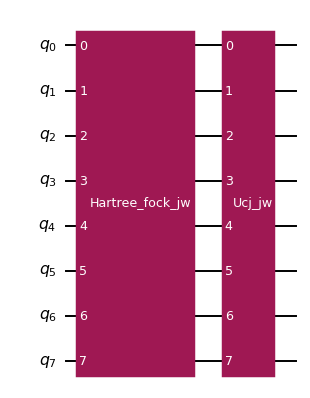

In [9]:
circuit = QuantumCircuit(qubits)
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(norb, nelec), qubits)
circuit.append(ffsim.qiskit.UCJOperatorJW(ucj_op), qubits)

circuit.draw("mpl", scale=0.7)

Let's decompose the circuit once:

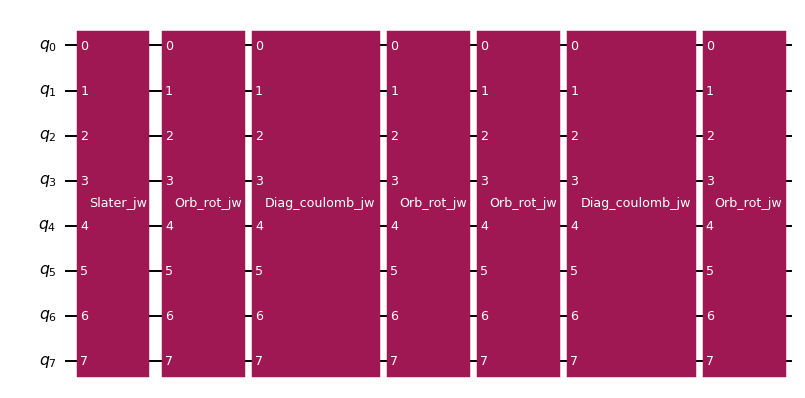

In [10]:
circuit.decompose().draw("mpl", scale=0.7)

There are two places that this circuit can be optimized:

- The first two gates can be merged into a single Slater determinant preparation gate.
- The fourth and fifth gates can be merged into a single orbital rotation gate.

The following code cell performs this optimization using a pass manager consisting of the [MergeOrbitalRotations](../api/ffsim.qiskit.rst#ffsim.qiskit.MergeOrbitalRotations) pass.

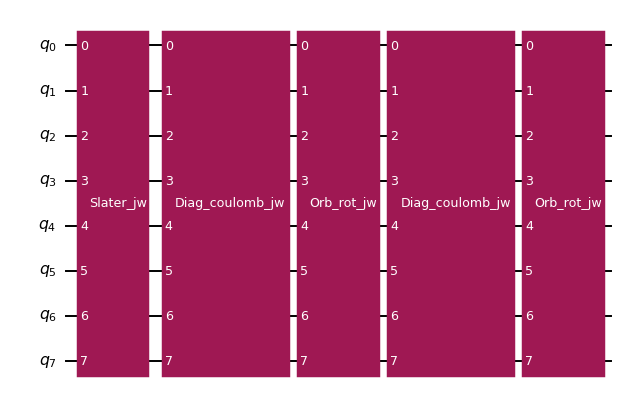

In [11]:
from qiskit.transpiler import PassManager

pass_manager = PassManager([ffsim.qiskit.MergeOrbitalRotations()])
transpiled = pass_manager.run(circuit.decompose())

transpiled.draw("mpl", scale=0.7)

Note that the MergeOrbitalRotations needs to be run on the decomposed circuit. Running it on the original circuit will have no effect because the orbital rotations are not exposed:

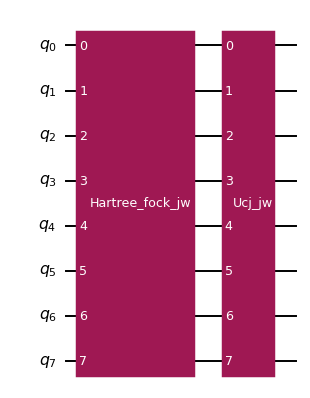

In [12]:
transpiled = pass_manager.run(circuit)

transpiled.draw("mpl", scale=0.7)

This issue can addressed by adding a [Decompose](https://docs.quantum.ibm.com/api/qiskit/qiskit.transpiler.passes.Decompose#decompose) pass that decomposes Hartree-Fock and UCJ gates before the MergeOrbitalRotations pass:

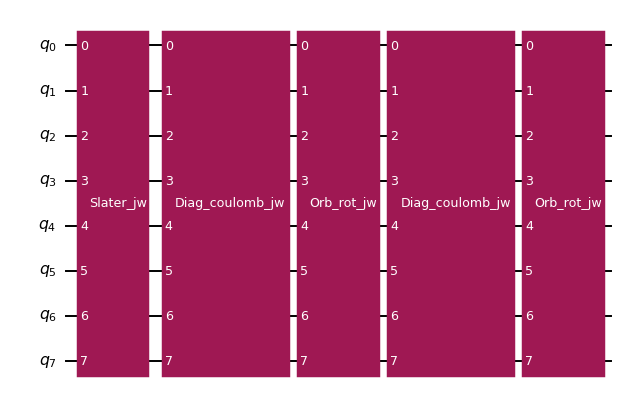

In [13]:
from qiskit.transpiler.passes import Decompose

pass_manager = PassManager(
    [
        Decompose(["hartree_fock_jw", "ucj_jw"]),
        ffsim.qiskit.MergeOrbitalRotations(),
    ]
)
transpiled = pass_manager.run(circuit)

transpiled.draw("mpl", scale=0.7)

The [pre_init_passes](../api/ffsim.qiskit.rst#ffsim.qiskit.pre_init_passes) function returns a generator that yields these transpiler passes. The function is so named because we recommend using these passes for the `pre_init` stage of Qiskit's transpiler pipeline. You can construct a pass manager using this function as follows:

In [14]:
pre_init = PassManager(list(ffsim.qiskit.pre_init_passes()))

Let's do a full transpilation of the circuit with and without the `pre_init` passes, and then print the final gate counts.

In [15]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Initialize quantum device backend
backend = GenericBackendV2(2 * norb, basis_gates=["cp", "xx_plus_yy", "p", "x"])

# Create a pass manager for circuit transpilation
pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

# Transpile the circuit without pre_init passes
transpiled = pass_manager.run(circuit)

# Transpile the circuit with pre_init passes
pass_manager.pre_init = pre_init
transpiled_opt = pass_manager.run(circuit)

print("Gate counts without pre_init passes:")
print(transpiled.count_ops())
print()
print("Gate counts with pre_init passes:")
print(transpiled_opt.count_ops())

Gate counts without pre_init passes:
OrderedDict([('cp', 56), ('xx_plus_yy', 48), ('p', 36), ('x', 4)])

Gate counts with pre_init passes:
OrderedDict([('cp', 56), ('xx_plus_yy', 32), ('p', 24), ('x', 4)])


The XXPlusYYGate count is significantly reduced when the `pre_init` passes are used.